### Load Original Images

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import os
from typing import List, Tuple, Optional
from tqdm import tqdm


# Function to load images and labels from a directory
def load_images(folder: str, n: Optional[int] = None) -> Tuple[List[np.ndarray], List[str]]:
    images = []
    labels = []
    label_folders = os.listdir(folder)
    for label_folder in tqdm(label_folders):
        count = 0
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            for img_file in glob(os.path.join(label_path, "*.jpg")):
                if n is not None and count >= n:
                    continue
                img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                images.append(img)
                labels.append(label_folder)
                count += 1

    assert len(images) == len(labels), "Mismatch in number of images and labels"

    return images, labels

num_samples = 5
def display_samples(images: List[np.ndarray], labels: List[str]) -> None:
    # display some sample images with their labels
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        rand = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[rand], cmap='gray')
        plt.title(f"Label: {labels[rand]}")
        plt.axis('off')
    plt.show()

# Load images and labels from train and test folders
train_images, train_labels = load_images("data/train")
# test_images, test_labels = load_images("data/test")

display_samples(train_images, train_labels)



### Circle Detection

Image 4692
(183, 275)


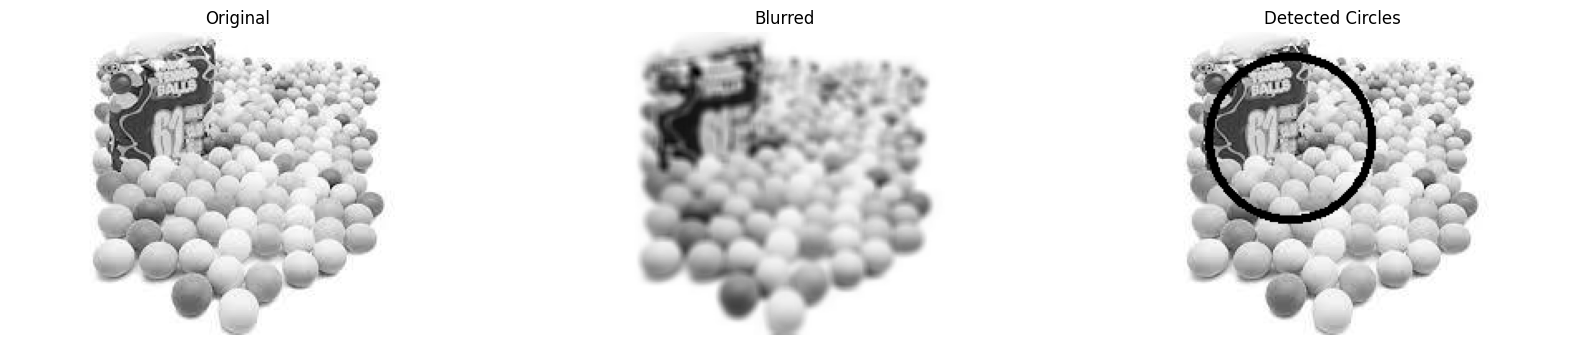

array([[112,  64,  49]])

In [23]:
import cv2
import sys


def downsample_image(image: np.ndarray) -> np.ndarray:
    # Downsample the image if its dimensions are larger than 1000
    max_dim = 1000
    if max(image.shape) > max_dim:
        scale = max_dim / max(image.shape)
        new_size = (int(image.shape[1] * scale), int(image.shape[0] * scale))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    return image


def detect_circles(image: np.ndarray, max = sys.maxsize, threshold = 100, show: bool = False) -> np.ndarray:
    circles = [[]]
    threshold = 100
    downsampled_image = downsample_image(image)
    blur = min(downsampled_image.shape) // 35
    blurred_image = cv2.blur(downsampled_image, (blur, blur))
    while True:
        circles = cv2.HoughCircles(
            blurred_image,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=20,
            param1=threshold,
            param2=threshold,
            minRadius=10,
            maxRadius=min(blurred_image.shape)
        )
        if circles is not None or threshold <= 5:
            break
        else:
            threshold -= 5
    
    circles = np.round(circles[0, :]).astype("int")

    if show:
        circle_image = image.copy()
        if circles is not None:
            for (x, y, r) in circles:
                cv2.circle(circle_image, (x, y), r, (0, 255, 0), 4)

        image_list = {
            "Original": image,
            "Blurred": blurred_image,
            "Detected Circles": circle_image
        }

        plt.figure(figsize=(20, 4))
        for i, (name, img) in enumerate(image_list.items()):
            plt.subplot(1, 3, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(name)
            plt.axis('off')

        plt.show()

    return circles[:max]


rand = np.random.randint(len(train_images))
print(f"Image {rand}")
print(train_images[rand].shape)
detect_circles(train_images[rand], show=True)


### Crop to ball

In [15]:
def crop_to_circle(img: np.ndarray, circles: np.ndarray) -> np.ndarray:
    cropped_imgs = []
    if circles is not None:
        for (x, y, r) in circles:
            cropped_img = img[y-r:y+r, x-r:x+r]
            cropped_imgs.append(cropped_img)
    return cropped_imgs


def remove_nones(images: List[np.ndarray], labels: List[str]) -> Tuple[List[np.ndarray], List[str]]:
    new_images = []
    new_labels = []
    for img, label in zip(images, labels):
        if img is not None and min(img.shape) >= 48:
            new_images.append(img)
            new_labels.append(label)
    return new_images, new_labels


cropped_images = []
cropped_labels = []
images_with_labels = list(zip(train_images, train_labels))
for img, label in tqdm(images_with_labels):
    circles = detect_circles(img)
    cis = crop_to_circle(img, circles)
    cropped_images.extend(cis)
    cropped_labels.extend([label] * len(cis))

processed_images, processed_labels = remove_nones(cropped_images, cropped_labels)

# Display some cropped images
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cropped_images[i], cmap='gray')
    plt.title(f"Label: {cropped_labels[i]}")
    plt.axis('off')
plt.show()

  2%|▏         | 122/5632 [00:21<16:25,  5.59it/s] 


KeyboardInterrupt: 

### Load Training Images

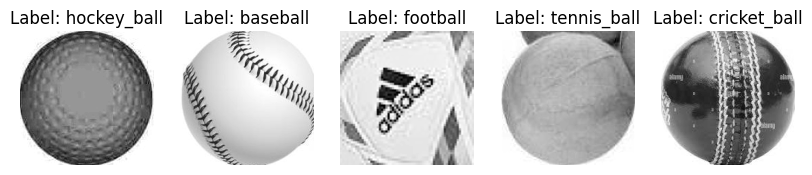

In [ ]:
ball_images, ball_labels = load_images("data/ball")
display_samples(ball_images, ball_labels)



### Downsample images to the same size

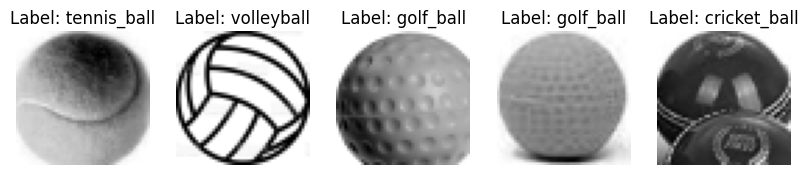

In [11]:
def downsample_images(images: List[np.ndarray]) -> List[np.ndarray]:
    downsampled_images = []
    min_height = min(img.shape[0] for img in images if img is not None and img.shape[0] > 0)
    min_width = min(img.shape[1] for img in images if img is not None and img.shape[1] > 0)
    shape = (min_width, min_height)
    for img in images:
        if img is None or img.shape[0] == 0 or img.shape[1] == 0:
            downsampled_images.append(None)
        else:
            downsampled_images.append(cv2.resize(img, shape, interpolation=cv2.INTER_AREA))
    return downsampled_images, shape


# Resize all images
downsampled_images, shape = downsample_images(ball_images)
display_samples(downsampled_images, ball_labels)

### Diversify Images

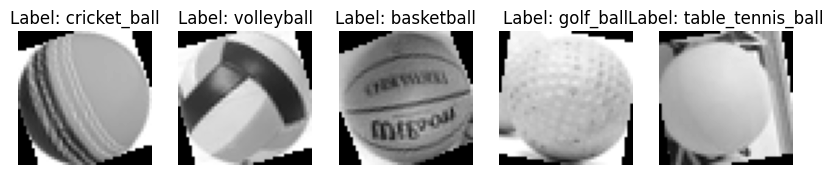

In [12]:
from scipy.ndimage import rotate
import random


def augment_image(image):
    # randomly rotate the image
    angle = random.uniform(-30, 30)
    rotated_image = rotate(image, angle, reshape=False)

    # randomly flip the image
    if random.choice([True, False]):
        flipped_image = np.fliplr(rotated_image)
    else:
        flipped_image = np.flipud(rotated_image)

    # pad to original size and return
    return flipped_image

# augment the images
augmented_images = [augment_image(image) for image in downsampled_images]
display_samples(augmented_images, ball_labels)

# combine the original and augmented images
all_images = np.concatenate((downsampled_images, np.array(augmented_images)))
all_labels = np.concatenate((ball_labels, ball_labels))

### CNN

In [30]:
import keras
import keras.models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


def circle_mask_images(images: List[np.ndarray]) -> np.ndarray:
    masked_images = []
    for image in images:
        # Get the dimensions of the image
        height, width = image.shape[:2]

        # Create a mask with a filled circle in the center
        mask = np.zeros((height, width), dtype=np.uint8)
        center = (width // 2, height // 2)
        radius = min(center[0], center[1], width - center[0], height - center[1])
        cv2.circle(mask, center, radius, 255, -1)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_images.append(masked_image)

    return np.array(masked_images)


def train_model(input_x: np.ndarray, input_y: np.ndarray, shape: Tuple[int, int], epochs: int) -> Tuple[keras.Sequential, keras.callbacks.History]:
    input_x = np.array(input_x)
    # input_x = input_x.reshape((input_x.shape[0], shape[0], shape[1], 1))
    
    # Convert string labels to numerical values
    label_encoder = LabelEncoder()
    input_y = label_encoder.fit_transform(input_y)
    input_y = to_categorical(input_y)
    num_classes = input_y.shape[1]

    train_images, val_images, train_labels, val_labels = train_test_split(input_x, input_y, test_size=0.2, random_state=42)
    train_images = circle_mask_images(train_images)
    val_images = circle_mask_images(val_images)

    model = keras.Sequential()

    # convolutional layer 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(shape[0], shape[1], 1), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # flatten the output
    model.add(Flatten())

    # fully connected layer
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # output layer
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model and print summary
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        # shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True,
        fill_mode='nearest'
    )

    train_images = np.expand_dims(train_images, axis=-1)
    # Fit the generator to your training data
    datagen.fit(train_images)

    # train the model
    history = model.fit(
        datagen.flow(train_images, train_labels, batch_size=32),
        epochs=epochs,
        validation_data=(val_images, val_labels),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )
    model.summary()
    model.save("ball_cnn.keras")
    return model, history

epochs = 50
model, history = train_model(downsampled_images, ball_labels, shape, epochs)

Epoch 1/50


c:\Users\jamie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jamie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1977 - loss: 2.9590 - val_accuracy: 0.2484 - val_loss: 2.7025
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2988 - loss: 2.2670 - val_accuracy: 0.2484 - val_loss: 2.9225
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3392 - loss: 2.1780 - val_accuracy: 0.3127 - val_loss: 2.2651
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4072 - loss: 1.9777 - val_accuracy: 0.3062 - val_loss: 2.5905
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4125 - loss: 1.9370 - val_accuracy: 0.3417 - val_loss: 2.3323
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4092 - loss: 1.9441 - val_accuracy: 0.4060 - val_loss: 2.0670
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4599 - loss: 1.8193 - val_accuracy: 0.3640 - val_loss: 1.9973
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4074 - loss: 1.9589 - val_accuracy: 0.3509 - val_loss: 2.

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,830,051 (14.61 MB)

 Trainable params: 1,276,363 (4.87 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2,552,728 (9.74 MB)

### Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# generate predictions
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, digits=4)
print("\nClassification Report:")
print(report)

# plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Training and validation loss/accuracy plots
history_dict = history.history  # Assuming `history` is the training history object
epochRange = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

# plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochRange, history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochRange, history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochRange, history_dict['loss'], label='Training Loss', marker='o')
plt.plot(epochRange, history_dict['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()